# TensorFlow Regression Example

## Creating Data

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [116]:
noise = np.random.randn(len(x_data))

In [117]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [118]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [119]:
my_data.head()

,X Data,Y
0,0.00000,4.619761
1,0.00001,4.408912
2,0.00002,5.303361
3,0.00003,5.494254
4,0.00004,4.937969


<AxesSubplot:xlabel='X Data', ylabel='Y'>

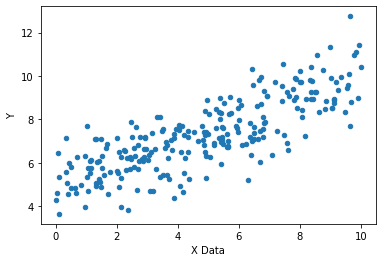

In [120]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [121]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

In [122]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [123]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [124]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [125]:
y_model = m*xph + b

** Loss Function **

In [126]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [127]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [128]:
init = tf.global_variables_initializer()

### Session

In [129]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):
        
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [130]:
model_m

0.5625147

In [131]:
model_b

4.8997946

### Results

In [132]:
y_hat = x_data * model_m + model_b

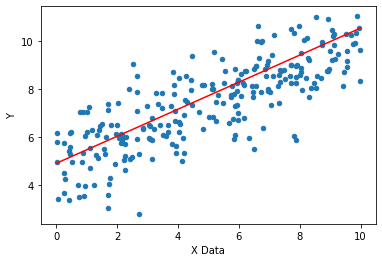

In [133]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [134]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [135]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Rachit\\AppData\\Local\\Temp\\tmpyp2w1cty', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [138]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [139]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [140]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [141]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [142]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Rachit\AppData\Local\Temp\tmpyp2w1cty\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 214.07126, step = 1
INFO:tensorflow:global_step/sec: 1790.54
INFO:tensorflow:loss = 20.969906, step = 101 (0.057 sec)
INFO:tensorflow:global_step/sec: 2445.53
INFO:tensorflow:loss = 7.3028955, step = 201 (0.041 sec)
INFO:tensorflow:global_step/sec: 2331.83
INFO:tensorflow:loss = 15.647152, step = 301 (0.043 sec)
INFO:tensorflow:global_step/sec: 2133.37
INFO:tensorflow:loss = 7.384008, step = 401 (0.046 sec)
INFO:tensorflow:global_step/sec: 2228.17
INFO:tensorflow:loss = 5.5250196, 

### Evaluation

In [143]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-25T21:26:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rachit\AppData\Local\Temp\tmpyp2w1cty\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Inference Time : 0.52571s
INFO:tensorflow:Finished evaluation at 2021-01-25-21:26:53
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0853746, global_step = 1000, label/mean = 7.5106134, loss = 4.3414984, prediction/mean = 7.27

In [144]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-25T21:26:54Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rachit\AppData\Local\Temp\tmpyp2w1cty\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Inference Time : 0.59059s
INFO:tensorflow:Finished evaluation at 2021-01-25-21:26:54
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1080726, global_step = 1000, label/mean = 7.5041995, loss = 4.4322906, prediction/mean = 7.23

In [145]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.0853746, 'label/mean': 7.5106134, 'loss': 4.3414984, 'prediction/mean': 7.271907, 'global_step': 1000}
eval metrics: {'average_loss': 1.1080726, 'label/mean': 7.5041995, 'loss': 4.4322906, 'prediction/mean': 7.2344337, 'global_step': 1000}


### Predictions

In [146]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [147]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rachit\AppData\Local\Temp\tmpyp2w1cty\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.3849916], dtype=float32)},
 {'predictions': array([5.022712], dtype=float32)},
 {'predictions': array([5.660433], dtype=float32)},
 {'predictions': array([6.298154], dtype=float32)},
 {'predictions': array([6.9358745], dtype=float32)},
 {'predictions': array([7.573595], dtype=float32)},
 {'predictions': array([8.211315], dtype=float32)},
 {'predictions': array([8.849036], dtype=float32)},
 {'predictions': array([9.486757], dtype=float32)},
 {'predictions': array([10.124477], dtype=float32)}]

In [148]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rachit\AppData\Local\Temp\tmpyp2w1cty\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [149]:
predictions

[array([4.3849916], dtype=float32),
 array([5.022712], dtype=float32),
 array([5.660433], dtype=float32),
 array([6.298154], dtype=float32),
 array([6.9358745], dtype=float32),
 array([7.573595], dtype=float32),
 array([8.211315], dtype=float32),
 array([8.849036], dtype=float32),
 array([9.486757], dtype=float32),
 array([10.124477], dtype=float32)]

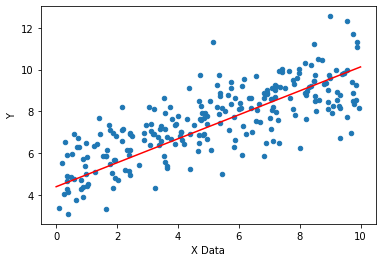

In [150]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Regression Exercise - 1

California Housing Data

This data set contains information about all the block groups in California from the 1990 Census. In this sample a block group on average includes 1425.5 individuals living in a geographically compact area. 

The task is to aproximate the median house value of each block from the values of the rest of the variables. 

 It has been obtained from the LIACC repository. The original page where the data set can be found is: http://www.liaad.up.pt/~ltorgo/Regression/DataSets.html.
 

The Features:
 
* housingMedianAge: continuous. 
* totalRooms: continuous. 
* totalBedrooms: continuous. 
* population: continuous. 
* households: continuous. 
* medianIncome: continuous. 
* medianHouseValue: continuous. 

## The Data

** Import the cal_housing.csv file with pandas. Separate it into a training (70%) and testing set(30%).**

In [151]:
import pandas as pd

In [152]:
housing = pd.read_csv('cal_housing_clean.csv')

In [153]:
housing.head()

,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [154]:
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
housingMedianAge,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
totalRooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
totalBedrooms,20640.0,537.898014,421.247906,1.0000,295.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
medianIncome,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
medianHouseValue,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [155]:
x_data = housing.drop(['medianHouseValue'],axis=1)

In [156]:
y_val = housing['medianHouseValue']

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(x_data,y_val,test_size=0.3,random_state=101)

### Scale the Feature Data

** Use sklearn preprocessing to create a MinMaxScaler for the feature data. Fit this scaler only to the training data. Then use it to transform X_test and X_train. Then use the scaled X_test and X_train along with pd.Dataframe to re-create two dataframes of scaled data.**

In [159]:
from sklearn.preprocessing import MinMaxScaler

In [160]:
scaler = MinMaxScaler()

In [161]:
scaler.fit(X_train)

MinMaxScaler()

In [162]:
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)

In [163]:
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

### Create Feature Columns

** Create the necessary tf.feature_column objects for the estimator. They should all be trated as continuous numeric_columns. **

In [164]:
housing.columns

Index(['housingMedianAge', 'totalRooms', 'totalBedrooms', 'population',
       'households', 'medianIncome', 'medianHouseValue'],
      dtype='object')

In [165]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

In [166]:
age = tf.feature_column.numeric_column('housingMedianAge')
rooms = tf.feature_column.numeric_column('totalRooms')
bedrooms = tf.feature_column.numeric_column('totalBedrooms')
pop = tf.feature_column.numeric_column('population')
households = tf.feature_column.numeric_column('households')
income = tf.feature_column.numeric_column('medianIncome')

In [167]:
feat_cols = [ age,rooms,bedrooms,pop,households,income]

** Create the input function for the estimator object. (play around with batch_size and num_epochs)**

In [168]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train ,batch_size=10,num_epochs=1000,
                                            shuffle=True)

** Create the estimator model. Use a DNNRegressor. Play around with the hidden units! **

In [169]:
model = tf.estimator.DNNRegressor(hidden_units=[6,6,6],feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Rachit\\AppData\\Local\\Temp\\tmpotkb719q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


##### ** Train the model for ~1,000 steps. (Later come back to this and train it for more and check for improvement) **

In [170]:
model.train(input_fn=input_func,steps=25000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Rachit\AppData\Local\Temp\tmpotkb719q\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 189948350000.0, step = 1
INFO:tensorflow:global_step/sec: 818.843
INFO:tensorflow:loss = 1142133600000.0, step = 101 (0.122 sec)
INFO:tensorflow:global_step/sec: 1012.54
INFO:tensorflow:loss = 546433400000.0, step = 201 (0.100 sec)
INFO:tensorflow:global_step/sec: 1012.8
INFO:tensorflow:loss = 581076800000.0, step = 301 (0.098 sec)
INFO:tensorflow:global_step/sec: 1055.45
INFO:tensorflow:loss = 437995000000.0, step = 401 (0.096 sec)
INFO:tensorflow:global_step/sec: 1023.14
INFO:ten

INFO:tensorflow:loss = 236785860000.0, step = 7501 (0.124 sec)
INFO:tensorflow:global_step/sec: 887.317
INFO:tensorflow:loss = 32176652000.0, step = 7601 (0.113 sec)
INFO:tensorflow:global_step/sec: 1055.45
INFO:tensorflow:loss = 81342230000.0, step = 7701 (0.095 sec)
INFO:tensorflow:global_step/sec: 1066.67
INFO:tensorflow:loss = 42372137000.0, step = 7801 (0.095 sec)
INFO:tensorflow:global_step/sec: 1066.68
INFO:tensorflow:loss = 125707930000.0, step = 7901 (0.093 sec)
INFO:tensorflow:global_step/sec: 1066.67
INFO:tensorflow:loss = 121989480000.0, step = 8001 (0.095 sec)
INFO:tensorflow:global_step/sec: 1066.68
INFO:tensorflow:loss = 69987205000.0, step = 8101 (0.093 sec)
INFO:tensorflow:global_step/sec: 1058.17
INFO:tensorflow:loss = 178445600000.0, step = 8201 (0.095 sec)
INFO:tensorflow:global_step/sec: 1077.44
INFO:tensorflow:loss = 55385145000.0, step = 8301 (0.092 sec)
INFO:tensorflow:global_step/sec: 1066.67
INFO:tensorflow:loss = 42110816000.0, step = 8401 (0.095 sec)
INFO:te

INFO:tensorflow:loss = 48691280000.0, step = 15401 (0.095 sec)
INFO:tensorflow:global_step/sec: 1089.86
INFO:tensorflow:loss = 44095398000.0, step = 15501 (0.093 sec)
INFO:tensorflow:global_step/sec: 1060.79
INFO:tensorflow:loss = 131827030000.0, step = 15601 (0.093 sec)
INFO:tensorflow:global_step/sec: 964.11
INFO:tensorflow:loss = 45793866000.0, step = 15701 (0.104 sec)
INFO:tensorflow:global_step/sec: 871.892
INFO:tensorflow:loss = 73795830000.0, step = 15801 (0.115 sec)
INFO:tensorflow:global_step/sec: 1007.5
INFO:tensorflow:loss = 203940940000.0, step = 15901 (0.099 sec)
INFO:tensorflow:global_step/sec: 1126.6
INFO:tensorflow:loss = 109810210000.0, step = 16001 (0.089 sec)
INFO:tensorflow:global_step/sec: 1044.45
INFO:tensorflow:loss = 163763240000.0, step = 16101 (0.096 sec)
INFO:tensorflow:global_step/sec: 1059.71
INFO:tensorflow:loss = 223522620000.0, step = 16201 (0.094 sec)
INFO:tensorflow:global_step/sec: 1066.67
INFO:tensorflow:loss = 105943060000.0, step = 16301 (0.095 sec

INFO:tensorflow:global_step/sec: 1095.55
INFO:tensorflow:loss = 93411150000.0, step = 23301 (0.092 sec)
INFO:tensorflow:global_step/sec: 1158.88
INFO:tensorflow:loss = 65199194000.0, step = 23401 (0.086 sec)
INFO:tensorflow:global_step/sec: 1095.57
INFO:tensorflow:loss = 54947824000.0, step = 23501 (0.091 sec)
INFO:tensorflow:global_step/sec: 1101.84
INFO:tensorflow:loss = 149902410000.0, step = 23601 (0.091 sec)
INFO:tensorflow:global_step/sec: 1055.45
INFO:tensorflow:loss = 109948320000.0, step = 23701 (0.094 sec)
INFO:tensorflow:global_step/sec: 1089.87
INFO:tensorflow:loss = 41429320000.0, step = 23801 (0.093 sec)
INFO:tensorflow:global_step/sec: 1089.85
INFO:tensorflow:loss = 53045410000.0, step = 23901 (0.091 sec)
INFO:tensorflow:global_step/sec: 1078.14
INFO:tensorflow:loss = 56240447000.0, step = 24001 (0.093 sec)
INFO:tensorflow:global_step/sec: 1023.14
INFO:tensorflow:loss = 142610970000.0, step = 24101 (0.099 sec)
INFO:tensorflow:global_step/sec: 1089.87
INFO:tensorflow:loss

** Create a prediction input function and then use the .predict method off your estimator model to create a list or predictions on your test data. **

In [171]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

In [172]:
pred_gen = model.predict(predict_input_func)

In [173]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rachit\AppData\Local\Temp\tmpotkb719q\model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


** Calculate the RMSE. Do this manually or use [sklearn.metrics](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) **

In [174]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'])

In [175]:
from sklearn.metrics import mean_squared_error

In [176]:
mean_squared_error(y_test,final_preds)**0.5

98196.34548365192